In [1]:
from pycocotools.coco import COCO
from pprint import pprint
from matplotlib.path import Path
import numpy as np
import json
import pandas as pd
from classify import *
from tqdm import tqdm_notebook as tqdm

# classify

In [2]:
anno_path = "../../yoshida_humansense/data/annotations/person_keypoints_val2017.json"
coco = COCO(anno_path)


loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [3]:
img_ids_byannos = []
cat_ids = 1
img_id =  coco.getImgIds(catIds=cat_ids)
anno_ids = coco.getAnnIds(img_id)

for i in range(len(anno_ids)):
    annos = coco.loadAnns(anno_ids[i])
    img_id_byannos = annos[0]['image_id']
    img_ids_byannos.append(img_id_byannos)


print(len(anno_ids), len(img_id))
print(len(img_ids_byannos))

11004 2693
11004


In [4]:
#人を取得
people = get_people(coco)

all_img = coco.getImgIds()
num_non_people = len(all_img)-len(people['img_people'])

for key in people:
    print(key, len(people[key]))


img_people 2693
anno_people 11004
img_people_byannos 11004


In [5]:
# keypointsの数がkよりアノテーション数が少ないものを除く
keypoints = get_enough_keypoints(13, people['img_people_byannos'], people['anno_people'], coco)

for key in keypoints:
    print(key, len(keypoints[key]))
    
num_img_keypoints, num_img_onlylesskeypoints = get_unique_num(keypoints['img_keypoints'], keypoints['img_onlylesskeypoints'] )    
print(len(num_img_onlylesskeypoints))

img_keypoints 2565
anno_keypoints 2565
img_lesskeypoints 8439
anno_lesskeypoints 8439
img_onlylesskeypoints 4259
1266


In [6]:
#両手首見えないor両足首が見えないものを除く
wrist_ankle = get_wrist_ankle(keypoints['img_keypoints'], keypoints['anno_keypoints'], coco)

for key in wrist_ankle:
    print(key, len(wrist_ankle[key]))
    
num_img_showpart, num_img_nonpart = get_unique_num(wrist_ankle['img_showpart'], wrist_ankle['img_nonpart'])

img_showpart 1842
anno_showpart 1842
img_nonpart 723
anno_nonpart 723


In [7]:
#片足でも膝が腰より高いもの or 両膝が見えないものを除く
lowlegs = get_lowlegs(wrist_ankle['img_showpart'], wrist_ankle['anno_showpart'], coco)
for key in lowlegs:
    print(key, len(lowlegs[key]))
    
num_img_lowlegs, num_img_highlegs = get_unique_num(lowlegs['img_lowlegs'], lowlegs['img_highlegs'])

img_lowlegs 1526
anno_lowlegs 1526
img_highlegs 316
anno_highlegs 316


In [8]:
#腰掛けている人を除く
# ratio : (上半身/下半身)の比率    (肩〜腰)/(腰〜足首)
#ratioより値が大きい(下半身の長さが上半身に対して短い)データを除く
standing = get_standing(1.0, lowlegs['img_lowlegs'], lowlegs['anno_lowlegs'],coco)
for key in standing:
    print(key, len(standing[key]))
    
num_img_standing, num_img_sitting = get_unique_num(standing['img_standing'], standing['img_sitting'])

img_standing 1452
anno_standing 1452
img_sitting 74
anno_sitting 74


# 関数が独立しているかテスト

In [11]:
#両手首見えないor両足首が見えないものを除く
wrist_ankle = get_wrist_ankle(people['img_people_byannos'], people['anno_people'], coco)

for key in wrist_ankle:
    print(key, len(wrist_ankle[key]))
    
num_img_showpart, num_img_nonpart = get_unique_num(wrist_ankle['img_showpart'], wrist_ankle['img_nonpart'])

img_showpart 2354
anno_showpart 2354
img_nonpart 8650
anno_nonpart 8650


In [12]:
# keypointsの数がkよりアノテーション数が少ないものを除く
keypoints = get_enough_keypoints(13, wrist_ankle['img_showpart'], wrist_ankle['anno_showpart'], coco)

for key in keypoints:
    print(key, len(keypoints[key]))
    
num_img_keypoints, num_img_onlylesskeypoints = get_unique_num(keypoints['img_keypoints'], keypoints['img_onlylesskeypoints'] )    
print(len(num_img_onlylesskeypoints))

img_keypoints 1842
anno_keypoints 1842
img_lesskeypoints 512
anno_lesskeypoints 512
img_onlylesskeypoints 207
175


In [13]:
#ratioより値が大きい(下半身の長さが上半身に対して短い)データを除く
#つまり腰掛けている人or 両肩が見えない人　or 両膝が見えていない人　を除く
# ratio : (上半身/下半身)の比率    (肩〜腰)/(腰〜足首)

standing = get_standing(1.0, keypoints['img_keypoints'], keypoints['anno_keypoints'],coco)
for key in standing:
    print(key, len(standing[key]))
    
num_img_standing, num_img_sitting = get_unique_num(standing['img_standing'], standing['img_sitting'])

img_standing 1625
anno_standing 1625
img_sitting 217
anno_sitting 217


In [14]:
lowlegs = get_lowlegs(standing['img_standing'], standing['anno_standing'], coco)
for key in lowlegs:
    print(key, len(lowlegs[key]))
    
num_img_lowlegs, num_img_highlegs = get_unique_num(lowlegs['img_lowlegs'], lowlegs['img_highlegs'])

img_lowlegs 1452
anno_lowlegs 1452
img_highlegs 173
anno_highlegs 173


# 表作成

                  img  anno  false_img  false_anno
num_keypoints    1427  2565       1266        8439
wrist_ankle      1132  1842        524         723
lowlegs           968  1526        258         316
standing_figure   931  1452         65          74


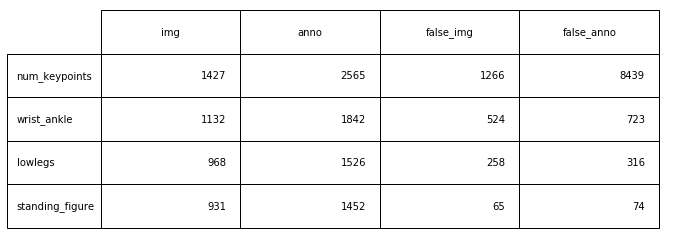

In [45]:
#表作成
num_img_keypoints, num_img_lesskeypoints = get_unique_num(keypoints['img_keypoints'], keypoints['img_lesskeypoints'] )   


data = []
num_keypointsids = [len(num_img_keypoints), 
                                      len(keypoints['anno_keypoints']), 
                                     len(num_img_onlylesskeypoints),
                                     len(keypoints['anno_lesskeypoints'])]
wrist_ankleids        = [len(num_img_showpart), 
                                      len(wrist_ankle['anno_showpart']),
                                      len(num_img_nonpart), 
                                      len(wrist_ankle['anno_nonpart'])]                     
lowlegsids               =[ len(num_img_lowlegs), 
                                      len(lowlegs['anno_lowlegs']), 
                                      len(num_img_highlegs),
                                      len(lowlegs['anno_highlegs'])]
standing_figureids = [len(num_img_standing), 
                                      len(standing['anno_standing']),
                                      len(num_img_sitting),
                                      len(standing['anno_sitting'])]

data += num_keypointsids, wrist_ankleids, lowlegsids, standing_figureids

# 行と列のラベルを定義
classification = ['num_keypoints','wrist_ankle', 'lowlegs', 'standing_figure']
img_anno = ['img', 'anno','false_img','false_anno' ]


# DataFrame作成
df = pd.DataFrame(data, index=classification, columns=img_anno)

print(df)

# 表を画像として描画
fig,ax = plt.subplots(figsize=((len(df.columns)+1)*2, (len(df)+1)*0.8))
ax.axis('off')
tbl = ax.table(cellText=df.values,
               bbox=[0,0,1,1],
               colLabels=df.columns,
               rowLabels=df.index)
# plt.savefig('table.png') #PNG画像出力
plt.show() 

# サンプル画像表示

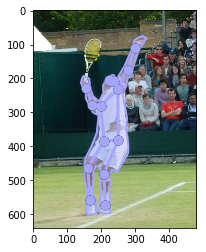

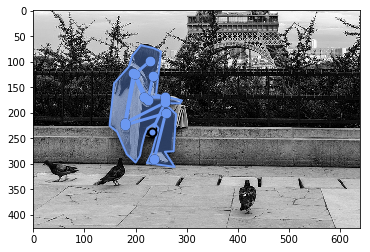

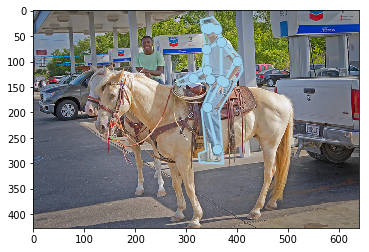

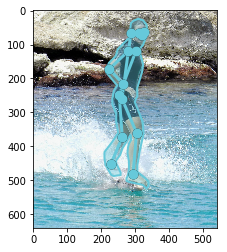

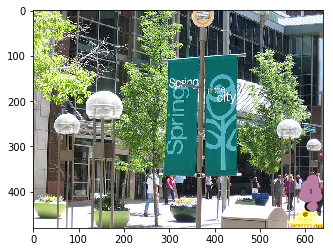

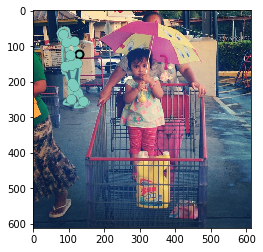

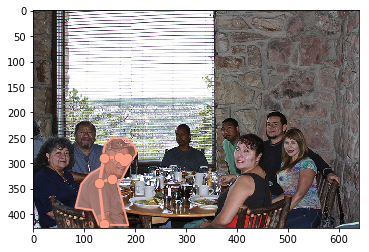

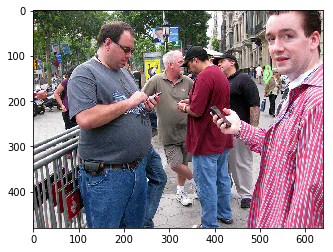

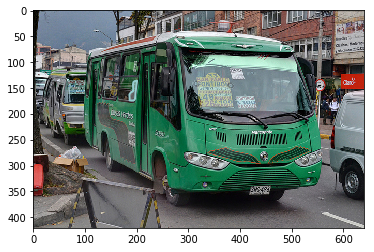

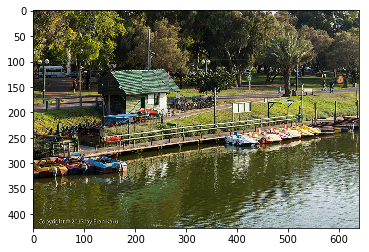

In [10]:
#num_keypintsの画像例
show_five_imgs(keypoints['img_keypoints'], keypoints['anno_keypoints'],coco)
show_five_imgs(keypoints['img_lesskeypoints'], keypoints['anno_lesskeypoints'],coco)

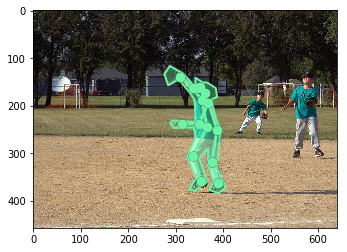

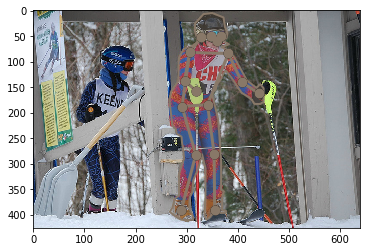

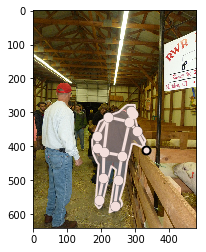

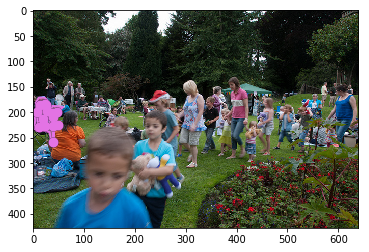

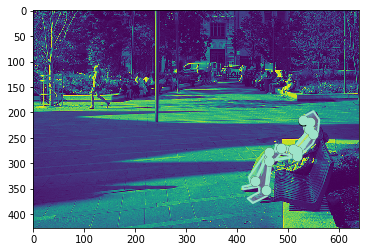

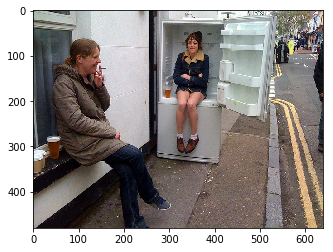

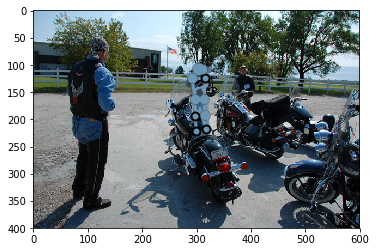

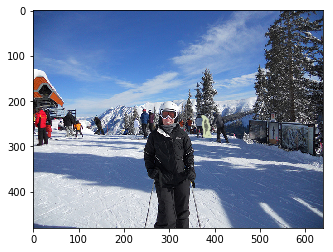

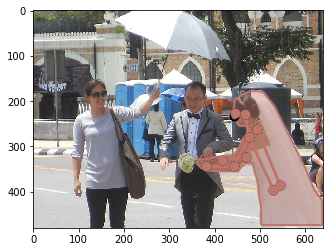

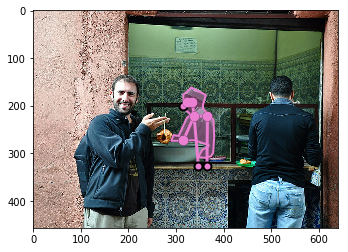

In [18]:
#手首足首それぞれどちらか一方見えるもの
show_five_imgs(wrist_ankle['img_showpart'], wrist_ankle['anno_showpart'],coco)
show_five_imgs(wrist_ankle['img_nonpart'], wrist_ankle['anno_nonpart'],coco)

In [3]:
#足が腰より低いもの
show_five_imgs(lowlegs['img_lowlegs'], lowlegs['anno_lowlegs'], coco)
show_five_imgs(lowlegs['img_highlegs'], lowlegs['anno_highlegs'], coco)

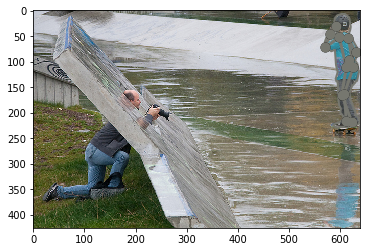

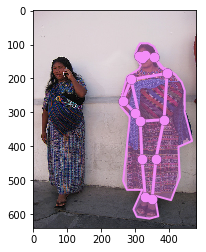

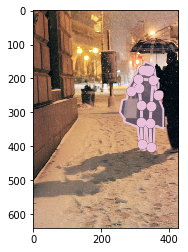

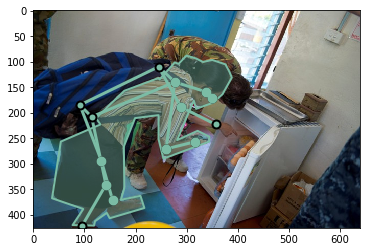

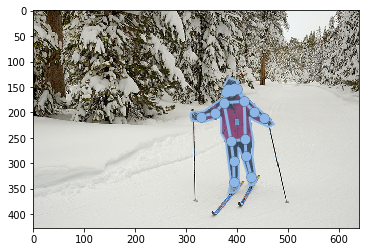

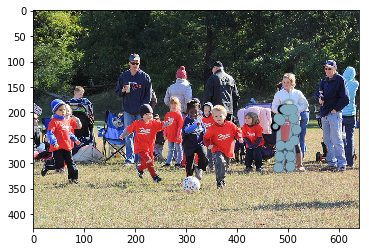

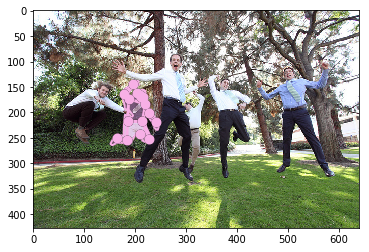

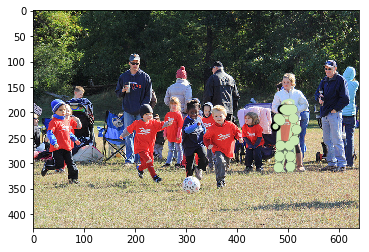

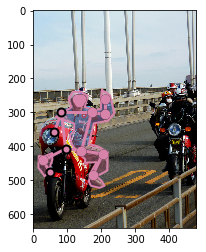

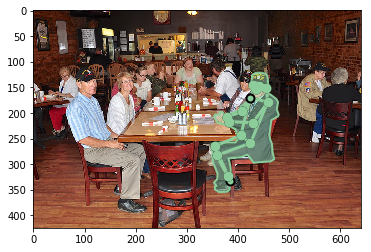

In [36]:
#立っている姿勢
show_five_imgs(standing['img_standing'], standing['anno_standing'], coco)
show_five_imgs(standing['img_sitting'], standing['anno_sitting'], coco)

# classifyしたデータのjsonファイル作成

In [10]:
#jsonファイルのパス
json_original = "../../yoshida_humansense/data/annotations/person_keypoints_val2017.json"
json_new = "classified_val2017test.json"

In [11]:
make_classifiedjson(json_original, json_new, standing['img_standing'],standing['anno_standing'], coco)

{"info": {"description": "COCO 2017 Dataset",
          "url": "http://cocodataset.org","version": "1.0",
          "year": 2017,"contributor": "COCO Consortium",
          "date_created": "2017/09/01"},
 "licenses": [{"url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
               "id": 1,"name": "Attribution-NonCommercial-ShareAlike License"},
              {"url": "http://creativecommons.org/licenses/by-nc/2.0/",
               "id": 2,"name": "Attribution-NonCommercial License"},
              {"url": "http://creativecommons.org/licenses/by-nc-nd/2.0/",
               "id": 3,"name": "Attribution-NonCommercial-NoDerivs License"},
              {"url": "http://creativecommons.org/licenses/by/2.0/","id": 4,"name": "Attribution License"},{"url": "http://creativecommons.org/licenses/by-sa/2.0/","id": 5,"name": "Attribution-ShareAlike License"},{"url": "http://creativecommons.org/licenses/by-nd/2.0/","id": 6,"name": "Attribution-NoDerivs License"},{"url": "http://flickr.com/commons/usage/","id": 7,"name": "No known copyright restrictions"},{"url": "http://www.usa.gov/copyright.shtml","id": 8,"name": "United States Government Work"}],

images
 {'coco_url': 'http://images.cocodataset.org/val2017/000000081988.jpg',
  'date_captured': '2013-11-20 22:59:13',
  'file_name': '000000081988.jpg',
  'flickr_url': 'http://farm7.staticflickr.com/6080/6038911779_36e4613d84_z.jpg',
  'height': 427,
  'id': 81988,
  'license': 4,
  'width': 640},

annotation{
"id": int, 
"image_id": int, 
"category_id": int, 
"segmentation": RLE or [polygon],
"area": float, 
"bbox": [x,y,width,height],
"iscrowd": 0 or 1,
}
annotation{
"keypoints": [x1,y1,v1,...], 
"num_keypoints": int,
"[cloned]": ...,
}
